In [42]:
from torch_june_analyser import Analyser
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import yaml
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 150
import matplotlib.pyplot as plt
from  matplotlib.colors import SymLogNorm

In [20]:
cc = yaml.safe_load(open("../../GradABM/Data/June/best_run.yaml"))
cc["system"]["device"] = "cpu"
an = Analyser.from_parameters(cc)
an.run()

In [21]:
date = "2020-05-10"

In [22]:
dd = an.get_gradient_cases_by_location(date)

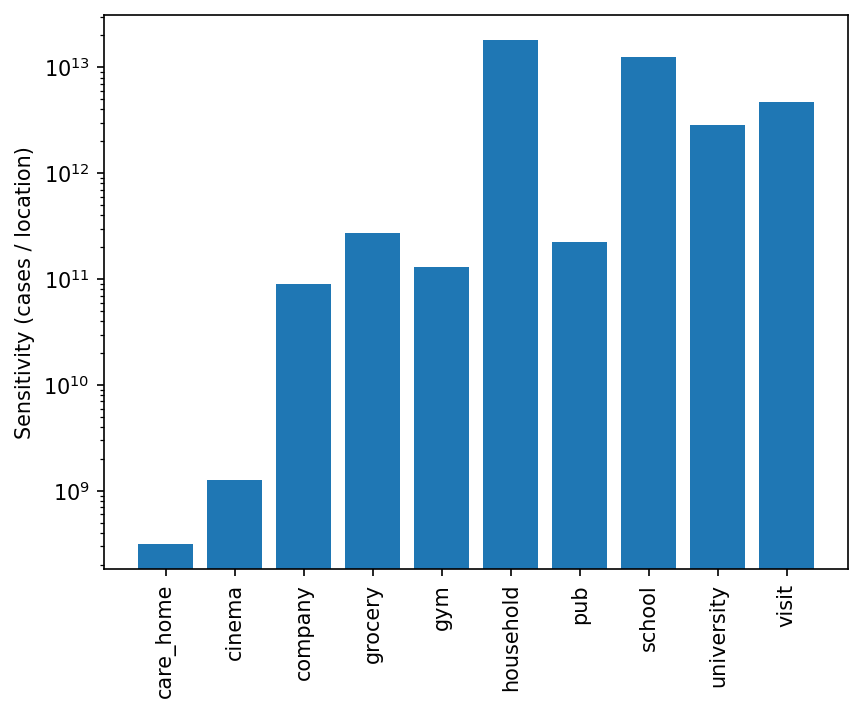

In [23]:
f, ax = plt.subplots()
ax.bar(dd.keys(), dd.values())
plt.xticks(rotation=90);
ax.set_yscale("log")
ax.set_ylabel(r"Sensitivity (cases / location)")
f.savefig("./total_sensitivity.png", dpi=150)

In [24]:
dd_deaths = an.get_gradient_deaths_by_location(date)

Text(0, 0.5, 'Sensitivity (deaths / location)')

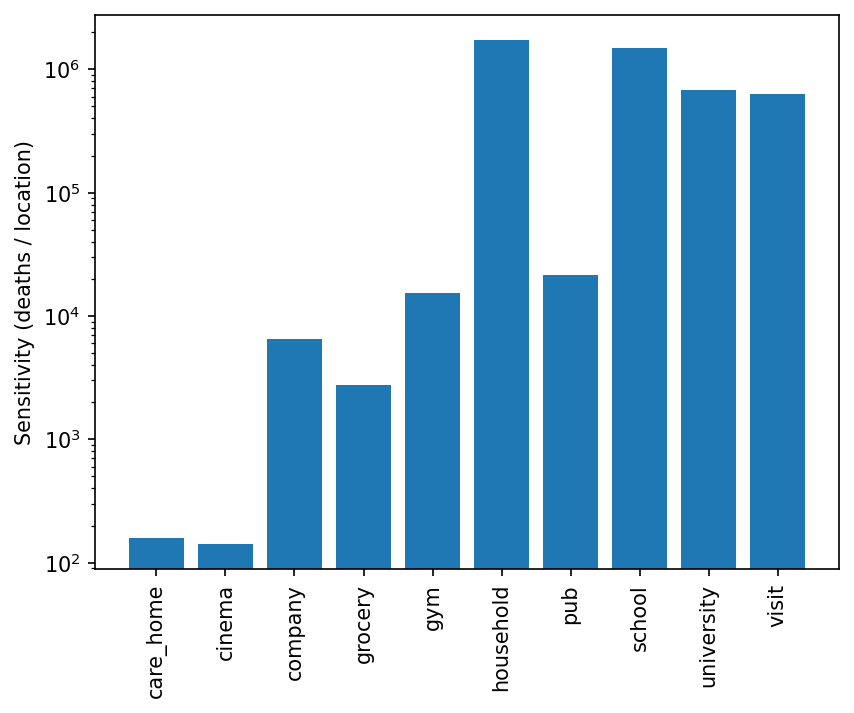

In [25]:
f, ax = plt.subplots()
ax.bar(dd_deaths.keys(), dd_deaths.values())
plt.xticks(rotation=90);
ax.set_yscale("log")
ax.set_ylabel(r"Sensitivity (deaths / location)")



In [26]:
dd_ages = an.get_gradient_cases_by_age_location(date)

Text(0, 0.5, 'Sensitivity (cases among 18 yo / location)')

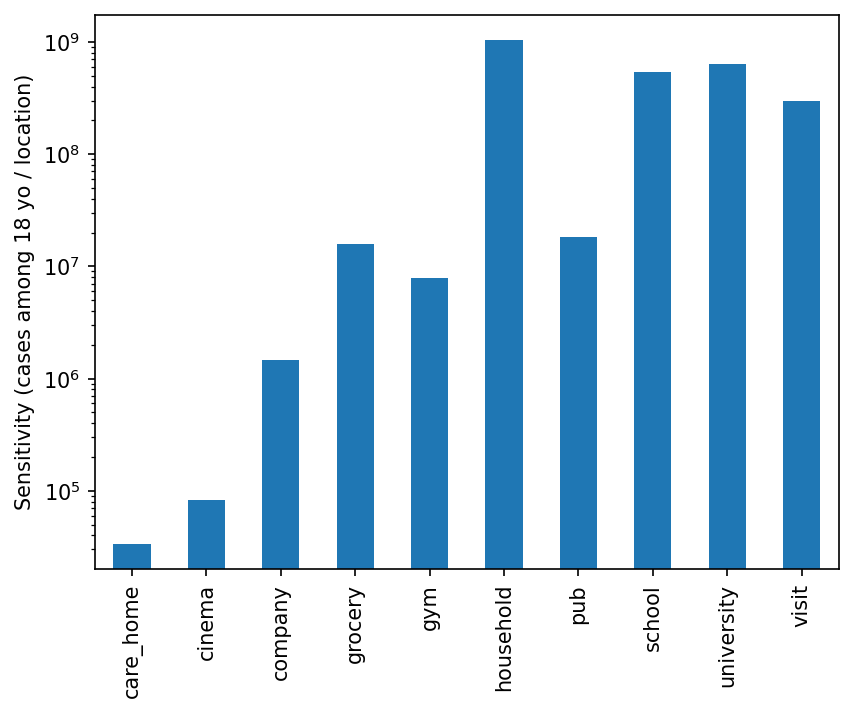

In [27]:
df = pd.DataFrame(dd_ages)
fig, ax = plt.subplots()
df = df[18]
df.plot.bar(ax=ax)
ax.set_yscale("log")
#ax.set_ylabel(r"$\frac{\mathrm{d}\mathrm{cases}_i}{\mathrm{d}\beta_j}$")
ax.set_ylabel(r"Sensitivity (cases among 18 yo / location)")

#ax.legend(title = "People aged <", loc="center left", bbox_to_anchor=(1, 0.5))

In [28]:
dd_ages_normed = an.get_gradient_normalised_cases_by_age_location(date)

In [33]:
df = pd.DataFrame(dd_ages_normed)

In [34]:
df

,18,25,45,65,100
care_home,-1.838232e+02,-2.068855e+02,14.884018,-4.116909e+01,-5.622436e+01
cinema,-7.401083e+02,-8.325885e+02,61.661316,-1.645723e+02,-2.251900e+02
company,-5.242259e+04,-5.900258e+04,4384.203125,-1.166123e+04,-1.595455e+04
grocery,-1.573906e+05,-1.770464e+05,13130.406250,-3.497950e+04,-4.787035e+04
gym,-7.488515e+04,-8.423775e+04,6254.742188,-1.663438e+04,-2.276771e+04
household,-1.054835e+07,-1.186182e+07,883543.000000,-2.338765e+06,-3.202704e+06
pub,-1.303812e+05,-1.466481e+05,10843.937500,-2.899584e+04,-3.967505e+04
school,-7.282024e+06,-8.192436e+06,609822.500000,-1.616874e+06,-2.213271e+06
university,-1.662646e+06,-1.868846e+06,135097.500000,-3.713754e+05,-5.076037e+05
visit,-2.724394e+06,-3.064069e+06,228063.750000,-6.043315e+05,-8.274684e+05


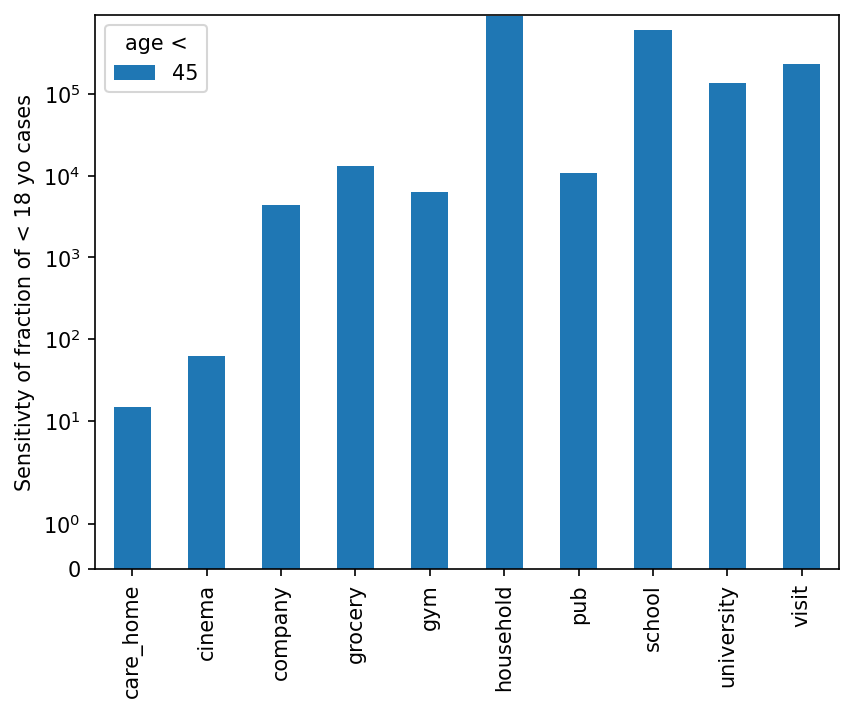

In [35]:
df = pd.DataFrame(dd_ages_normed)
f, ax = plt.subplots()
df = df[45]
df.plot.bar(ax=ax)
ax.legend(title="age <")
ax.set_ylabel(r"Sensitivty of fraction of < 18 yo cases")

ax.set_yscale("symlog")
#ax.set_ylabel(r"$\frac{\mathrm{d}\mathrm{cases}_i}{\mathrm{d}\beta_j}$")


In [51]:
#dd_ethn = an.get_gradient_normalised_cases_by_ethnicity_location(date)

def get_gradient_normalised_cases_by_ethnicity_location():
    an.runner.zero_grad()
    if an.results is None:
        raise ValueError("Need to run Runner first")
    ethnicities = ["A", "B", "C", "D", "E"]
    ret = {}
    for ethnicity in tqdm(ethnicities):
        ret[ethnicity] = {}
        mask = np.char.startswith(an.runner.data["agent"].ethnicity, ethnicity)
        cases = an.runner.data["agent"].is_infected[mask].sum() / an.runner.data["agent"].is_infected.sum()
        cases.backward(retain_graph=True)
        for name in an._get_network_names():
            ret[ethnicity][name] = an.runner.model.infection_networks.networks[
                name
            ].log_beta.grad.item()
    return ret


In [52]:
dd_norm_ethn = get_gradient_normalised_cases_by_ethnicity_location()

100%|█████████████████████████████████████████████████████████| 5/5 [09:00<00:00, 108.19s/it]


In [54]:
df = pd.DataFrame(dd_norm_ethn)

In [55]:
df

,A,B,C,D,E
care_home,-6.100042e+01,-9.349860e+01,6.984848,2.095165e+01,-0.000072
cinema,-2.467986e+02,-3.786466e+02,27.387604,8.434509e+01,-0.000359
company,-1.751559e+04,-2.692090e+04,1900.880859,5.977604e+03,-0.012207
grocery,-5.250594e+04,-8.050897e+04,5836.742188,1.793644e+04,-0.074219
gym,-2.499255e+04,-3.830477e+04,2779.230469,8.533763e+03,-0.033203
household,-3.524296e+06,-5.386294e+06,396617.500000,1.201947e+06,-3.375000
pub,-4.344718e+04,-6.662261e+04,4852.585938,1.485274e+04,-0.063477
school,-2.432607e+06,-3.729132e+06,269046.250000,8.301338e+05,-3.687500
university,-5.497996e+05,-8.430875e+05,63536.375000,1.889681e+05,-1.109375
visit,-9.099286e+05,-1.392118e+06,101986.125000,3.104473e+05,-1.375000


<BarContainer object of 5 artists>

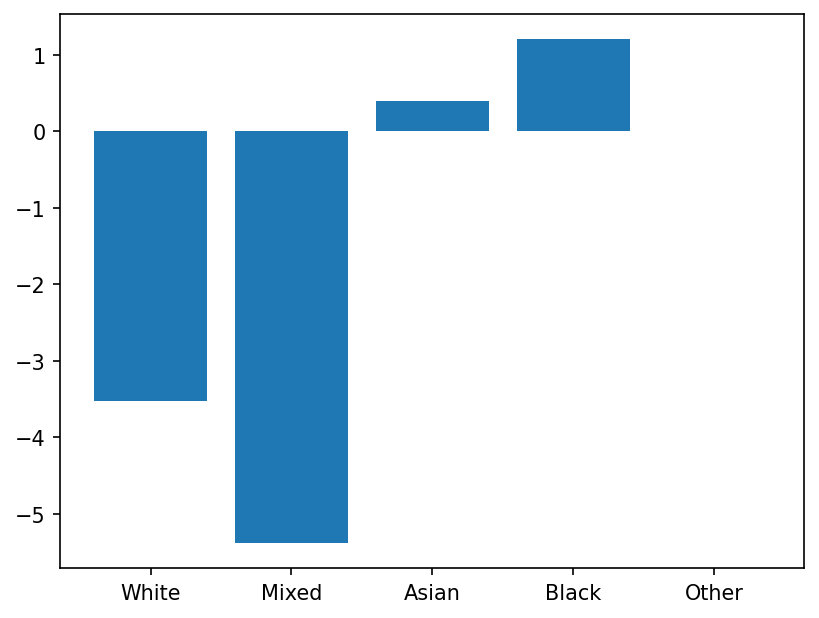

In [68]:
f, ax = plt.subplots()
names = ["White", "Mixed", "Asian", "Black", "Other"]
ax.bar(names, df.loc["household"] / 1e6)
#ax.set_yscale("symlog")

In [ ]:
#for ethn in ["A", "B", "C", "D", "E"]:
#    cols = [col for col in df.columns if col.startswith(ethn)]
#    df[ethn] = df[cols].mean(1)
#    df = df.drop(columns=cols)

In [ ]:
import yaml
asd = yaml.safe_load(open("/cosma/home/dp004/dc-quer1/june/JUNE/june/configs/defaults/demography/ethnicity_encodings.yaml"))
names = []
for bb in asd:
    fine = asd[bb]
    for key in fine:
        if key == "broad":
            continue
        name = fine[key]
        if name.startswith("English"):
            name = "British White"
        if name.startswith("Irish"):
            name = "Irish White"
        names.append(name)

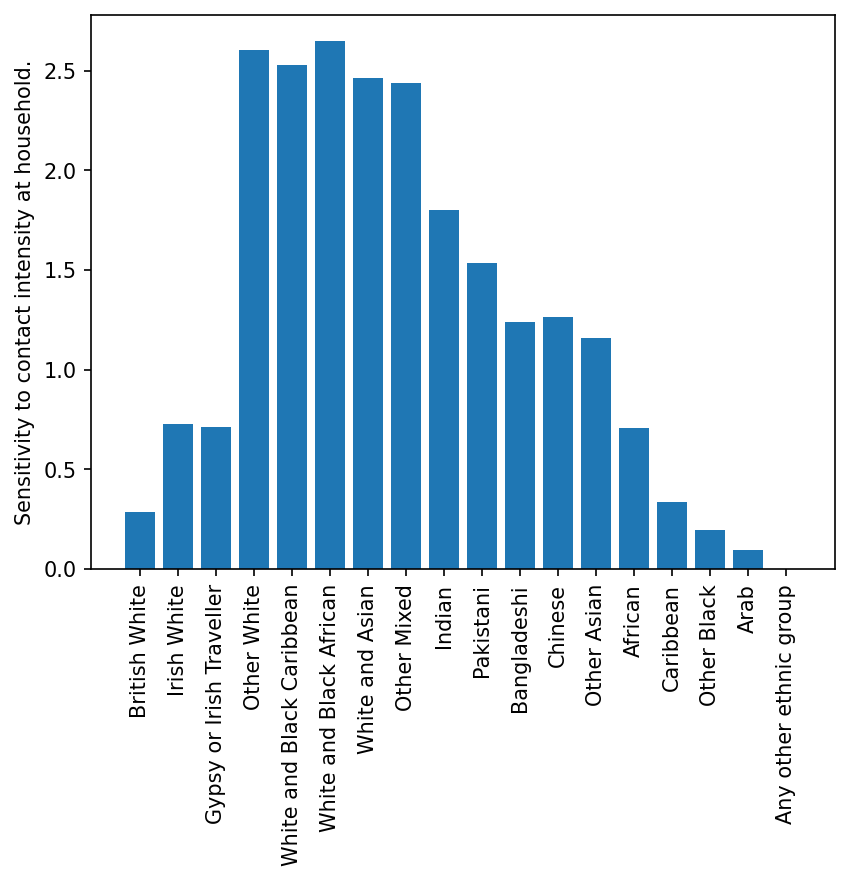

In [53]:
f, ax = plt.subplots()
ax.bar(names, df.loc["household"].values)
ax.set_ylabel("Sensitivity to contact intensity at household.")
#ax.set_xlabel("Ethnicity")
plt.xticks(rotation=90);

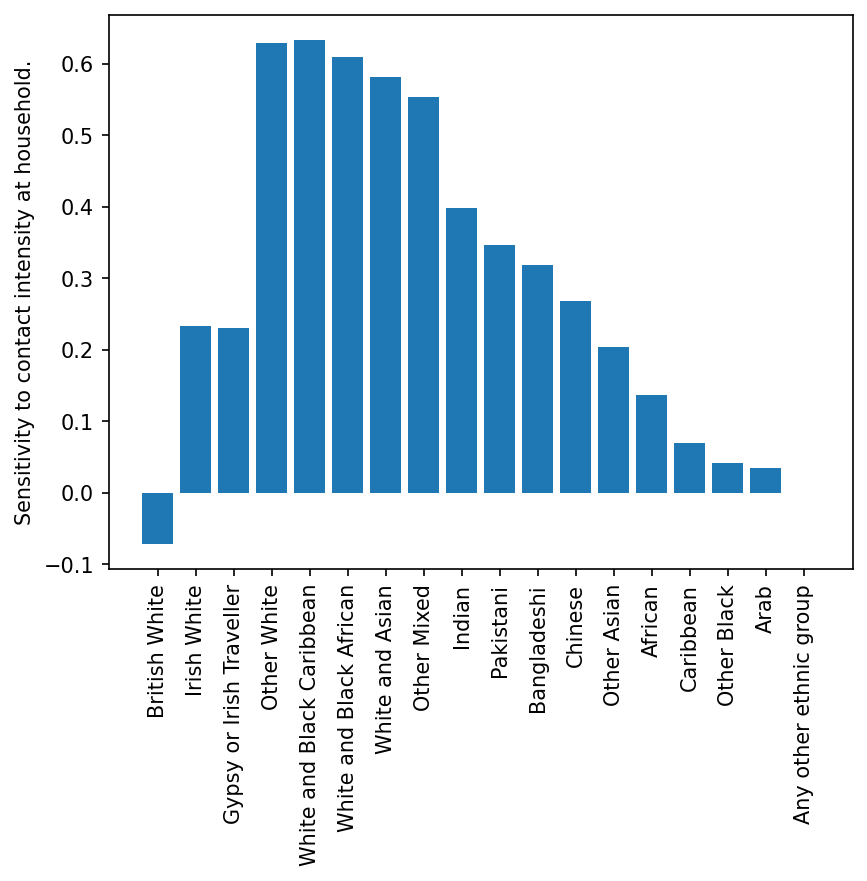

In [55]:
f, ax = plt.subplots()
ax.bar(names, df.loc["school"].values)
ax.set_ylabel("Sensitivity to contact intensity at household.")
#ax.set_xlabel("Ethnicity")
plt.xticks(rotation=90);

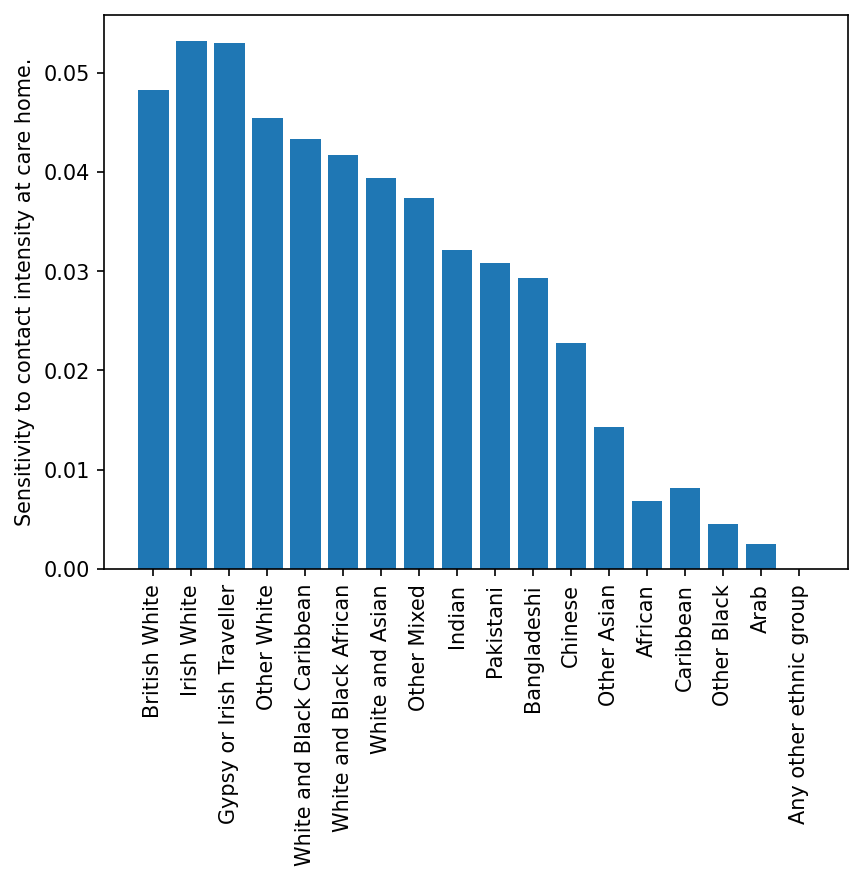

In [62]:
f, ax = plt.subplots()
ax.bar(names, df.loc["care_home"].values)
ax.set_ylabel("Sensitivity to contact intensity at care home.")
#ax.set_xlabel("Ethnicity")
plt.xticks(rotation=90);

In [4]:
newton_step = an.get_newton_step(date)

/tmp/ipykernel_234075/3208631084.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newton_step.keys(), rotation=90);


Text(0, 0.5, 'Parameter variation')

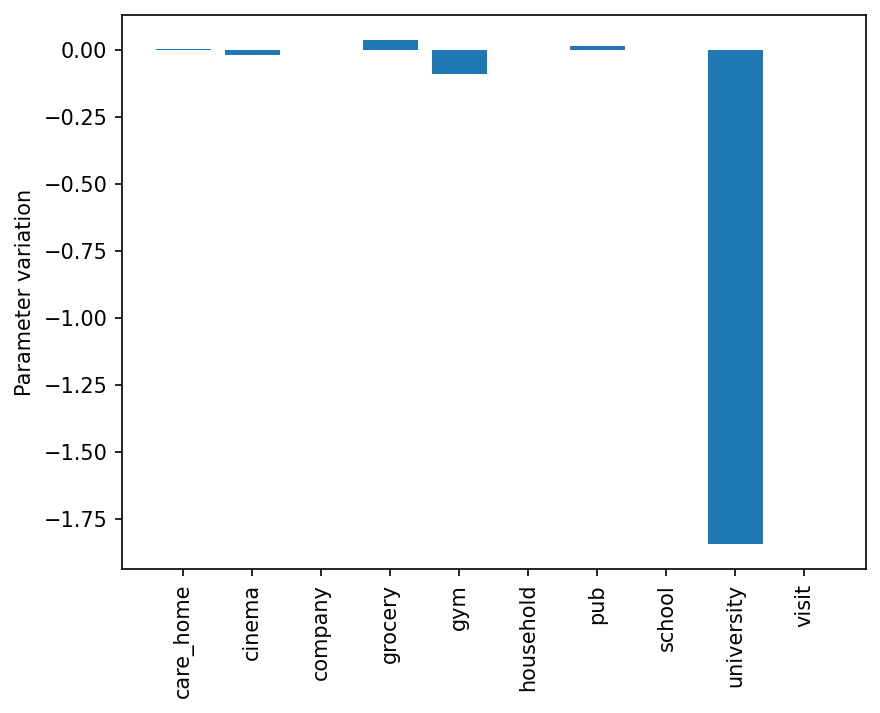

In [5]:
fig, ax = plt.subplots()
ax.bar(newton_step.keys(), newton_step.values())
ax.set_xticklabels(newton_step.keys(), rotation=90);
ax.set_ylabel("Parameter variation")

In [102]:
initial_date = "2020-03-01"
grad_per_day = defaultdict(lambda: [])
for day in range(40):
    date = datetime.strptime(initial_date, "%Y-%m-%d") + timedelta(days=day)
    date = str(date.date())
    dd = an.get_gradient_cases_by_location(date)
    total_gradient = np.sqrt(np.sum(np.array(list(dd.values()))**2))
    for key in dd:
        grad_per_day[key].append(dd[key] / total_gradient)


/tmp/ipykernel_91182/1039227143.py:9: RuntimeWarning: invalid value encountered in double_scalars
  grad_per_day[key].append(dd[key] / total_gradient)


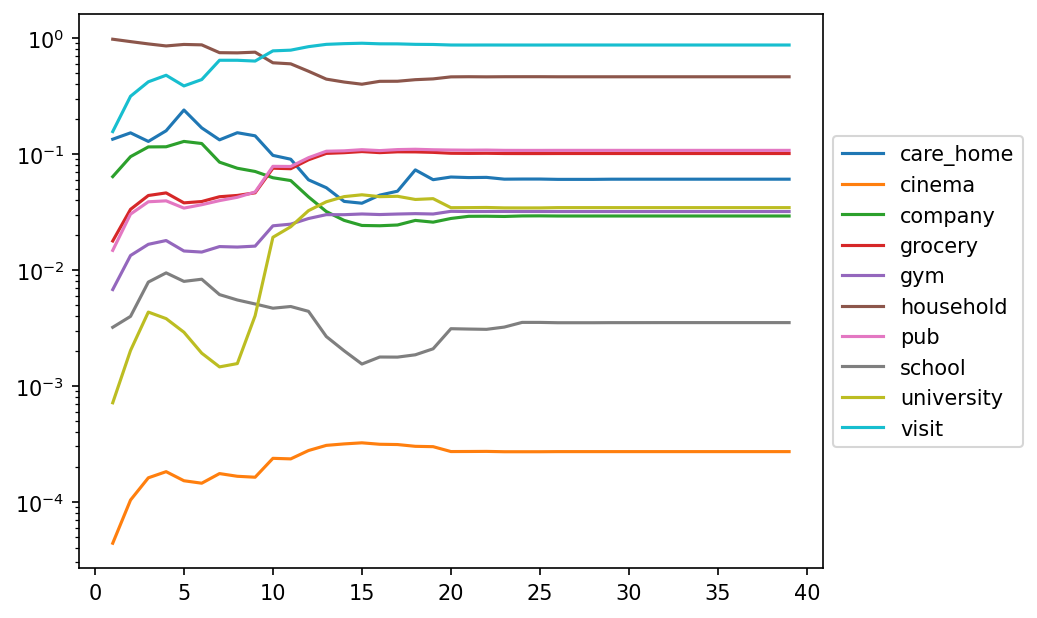

In [103]:
f, ax = plt.subplots()
for key in grad_per_day:
    ax.plot(grad_per_day[key], label = key)
ax.set_yscale("log")
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))